# Praca domowa nr 2
## Piotr Fic

In [116]:
#Pakiety
import pandas as pd
import numpy as np
import sklearn
import category_encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
np.random.seed(123)

### Wczytanie zbioru danych

In [24]:
df = pd.read_csv("allegro-api-transactions.csv")

### Krótkie obejrzenie zbioru

In [25]:
df.head(5)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
lp                        420020 non-null int64
date                      420020 non-null object
item_id                   420020 non-null int64
categories                420020 non-null object
pay_option_on_delivery    420020 non-null int64
pay_option_transfer       420020 non-null int64
seller                    420020 non-null object
price                     420020 non-null float64
it_is_allegro_standard    420020 non-null int64
it_quantity               420020 non-null int64
it_is_brand_zone          420020 non-null int64
it_seller_rating          420020 non-null int64
it_location               420020 non-null object
main_category             420020 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 44.9+ MB


## Część I: kodowanie zmiennych kategorycznych

## Target encoding: it_location

Zmienna 'it_location' jest typu string. Pojawia się problem wielkich i małych liter, które mogą spowodować powstanie niepotrzebnie wielu kategorii dla tej samej lokalizacji np. Warszawa!=warszawa. Z tego powodu zanim przystąpię do target encoding-u, transformuję stringi do małych liter. Nie pomoże to na błędy pisowni ale możemy liczyć, że takich jest niewiele bo użytkownikom powinno zależeć na poprowności adresu.

In [27]:
#Kopia df na potrzeby wykonania poleceń
data = df.copy()

#Transformacja stringów
data['it_location'] = data['it_location'].str.lower()

print("Unikalna liczba lokalizacji (czyli kategorii):")
data['it_location'].nunique()

Unikalna liczba lokalizacji (czyli kategorii):


7903

In [28]:
cat_occ = data['it_location'].value_counts()
print("Liczba kategorii o mniej niż 3 wystąpieniach:")
cat_occ[cat_occ <= 2].count()

Liczba kategorii o mniej niż 3 wystąpieniach:


3348

Lokalizacja jako zmienna kategoryczna generuje wiele unikalnych wartości, dodatkowo około 40% kategorii ma mniej niż 3 wystąpienia. Wymusza to zastosowanie znacznego wygładzania aby encoding tych kategorii nie był zaburzony przez małą liczbę obserwacji. Powinno to zapobiec over-fittingowi.

In [29]:
#Target encoding zmienna: 'it_location', target: 'price'
#Parametr smoothing domyślny
te = category_encoders.target_encoder.TargetEncoder()
enc_te = te.fit_transform(data['it_location'], data['price'])
enc_te.head()

,it_location
0,84.132898
1,84.132898
2,64.883187
3,35.433365
4,73.772916


In [30]:
#Target encoding zmienna: 'it_location', target: 'price'
#Parametr smoothing=50
te = category_encoders.target_encoder.TargetEncoder()
te.set_params(smoothing=50)
enc_te = te.fit_transform(data['it_location'], data['price'])
enc_te.head()

,it_location
0,84.132898
1,84.132898
2,64.883187
3,40.110974
4,73.772916


In [31]:
print(cat_occ['warszawa'])
print(cat_occ['leszno'])
print(cat_occ['wola krzysztoporska'])

27042
1142
104


Parametr smoothing\
Ustawienie wartości parametru na 50 spowodowało, że dla kategorii z dużą liczbą wystąpień takich jak 'warszawa' (indeksy: 0-1) i 'leszno' (indeks: 2) nadany encoding nie zmienił się względem domyślnej wartości parametru. Natomiast dla kategorii z małą liczbą wystąpień - w stosunku do rozmiaru zbioru - 'wola krzysztoporska' (indeks: 3) możemy zauważyć wygładzenie wartości encodingu. Optymalny dobór wartości parametru wymagał by szerszej analizy, lecz uzyskany efekt jest satysfakcjonujący.

Porównanie do one-hot encoding\
Zastosowanie metody one-hot w przypadku zmiennej 'it_location' spowodowało by utworzenie 7902 nowych kolumn co w praktyce nie ma szans powodzenia ze względu na ograniczenia pamięciowe i nie wydaje się zbyt racjonalne. Ponadto one-hot encoding rozprasza jedną cechę na wiele wymiarów co intuicyjnie obniża jej znaczenie, szczególnie względem zmiennych ciągłych gdzie wartości będą większe niż tylko binarne. Minusem metody target-encoding jest podatność na nierównomierny rozkład kategorii i over-fitting co wymusza stosowanie wygładzania.

## Encoding zmiennej 'main_category'

In [32]:
#Kopia df na potrzeby wykonania poleceń
data = df.copy()

#Przegląd zmiennej
print(data['main_category'].value_counts())

print("Liczba unikalnych kategorii: " + str(len(data['main_category'].unique())))

Dom i Ogród                            91042
Odzież, Obuwie, Dodatki                54257
Motoryzacja                            45941
Dla Dzieci                             42107
Uroda                                  28096
Sport i Turystyka                      27532
RTV i AGD                              20341
Telefony i Akcesoria                   19805
Komputery                              14491
Zdrowie                                13166
Książki i Komiksy                      11572
Delikatesy                              8074
Gry                                     7150
Rękodzieło                              6574
Kolekcje                                6146
Przemysł                                5959
Biżuteria i Zegarki                     5808
Biuro i Reklama                         3194
Fotografia                              2381
Muzyka                                  1961
Antyki i Sztuka                         1214
Konsole i automaty                      1053
Filmy     

Kolumna jest uporządkowana i bez przeszkód możemy przejść do implementacji encodingu.

### One-hot encoding

In [33]:
onehot_en = OneHotEncoder(categories='auto')
enc_onehot = onehot_en.fit_transform(data['main_category'].values.reshape(-1,1)).toarray()
print(enc_onehot)
print("Liczba utworzonych kolumn: " + str(len(enc_onehot[1])))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Liczba utworzonych kolumn: 27


### Binary encoding

Metoda polega na zakodowaniu informacji o kategorii w formie binarnej. Tworzona jest odpowiednia liczba kolumn aby móc zakodować wszystkie wartości. Dzięki temu nie przekazujemy dodatkowej wartości dla kategorii jak w kodowaniu int-ami w miejscu oraz tworzymy mniej kolumn niż w metodzie one-hot.

In [34]:
binary_en = category_encoders.BinaryEncoder()
enc_binary = binary_en.fit_transform(data['main_category'].values.reshape(-1,1))
print(enc_binary)
print("Liczba utworzonych kolumn: " + str(len(enc_binary.iloc[1])))

        0_0  0_1  0_2  0_3  0_4  0_5
0         0    0    0    0    0    1
1         0    0    0    0    1    0
2         0    0    0    0    1    1
3         0    0    0    1    0    0
4         0    0    0    0    1    0
...     ...  ...  ...  ...  ...  ...
420015    0    0    0    1    1    0
420016    0    0    1    0    0    1
420017    0    0    0    0    1    0
420018    0    0    1    0    0    0
420019    0    0    0    1    1    1

[420020 rows x 6 columns]
Liczba utworzonych kolumn: 6


### James-Stein encoder

Metoda oparta na wyliczaniu średniej ze zmiennej target dla danej kategorii oraz całej całości obserwacji . Podobna do klasycznego target-encoding, lecz tak skonstruowana aby średnie dla kategorii przesuwać w kierunku średniej ogółu. Potencjalnie ciekawa metoda, gdyż odpowiedni dobór parametru rozmywania średnich pozwala osiągnąć optymalny rezultat między\
under- a over-fittingiem.

In [35]:
js_en = category_encoders.JamesSteinEncoder()
enc_js = js_en.fit_transform(data['main_category'], data['price'])
enc_js.head()

,main_category
0,101.735793
1,75.894257
2,73.179117
3,25.346202
4,75.894257


Dodatkowo z ciekawości porównam James-Stein i target-encoding dla kolumny 'it_location'.

In [36]:
data = df.copy()
data['it_location'] = data['it_location'].str.lower()

js_en_loc = category_encoders.JamesSteinEncoder()
enc_js_loc = js_en_loc.fit_transform(data['it_location'], data['price'])
print("James-Stein: ")
print(enc_js_loc.head())
print("Target-encoding (smooth=50): ")
print(enc_te.head())

James-Stein: 
   it_location
0    79.048949
1    79.048949
2    66.758534
3    36.283149
4    74.299479
Target-encoding (smooth=50): 
   it_location
0    84.132898
1    84.132898
2    64.883187
3    40.110974
4    73.772916


# Część II: braki danych

In [124]:
#Wybór kolumn
num_data = df[['price', 'it_seller_rating', 'it_quantity']]

#Redukcja rozmiaru do 10% rekordów
num_data = num_data.drop(num_data.sample(frac=.9).index)
print("Pozostała liczba rekordów:")
print(len(num_data))

Pozostała liczba rekordów:
42002


## Imputacja braków

Postanowiłem zmierzyć wyniki imputacji metodą najbliższych sąsiadów. Dokładność imputacji zmierzę miarą RMSE powtarzając 10 krotnie doświadczenie dla obu przygotowanych zbiorów. Parametr liczby sąsiadów ustalę według popularnej konwencji sqrt(n), gdzie n - liczba obserwacji.

In [133]:
def input_measure(df):
    knn_imp = KNNImputer(n_neighbors=200)
    result = pd.DataFrame(knn_imp.fit_transform(df))
    err1 = mean_squared_error(num_data['it_seller_rating'], result[1], squared=False)
    err2 = mean_squared_error(num_data['it_quantity'], result[2], squared=False)
    return(err1, err2)

In [134]:
#df na wyniki
case1 = pd.DataFrame(columns = ["seller_rating"])
case2 = pd.DataFrame(columns = ["seller_rating", "quantity"])

#przeprowadzenie prób
for i in range(10):
    #Przygotowanie zbioru z brakami nr 1
    mis1 = num_data.copy()
    rand_id_1 = mis1.sample(round(0.1*len(mis1))).index
    mis1.loc[rand_id_1, 'it_seller_rating'] = None

    #Przygotowanie zbioru z brakami nr 2
    mis2 = mis1.copy()
    rand_id_2 = mis2.sample(round(0.1*len(mis2))).index
    mis2.loc[rand_id_2, 'it_quantity'] = None
    
    r1_1, r1_2 = input_measure(mis1)
    r2_1, r2_2 = input_measure(mis2)
    
    case1.loc[i] = [r1_1]
    case2.loc[i] = [r2_1, r2_2]

### Dane statystyczne na temat oryginalnych wartości

In [144]:
pd.DataFrame(num_data[['it_seller_rating', 'it_quantity']]).describe()

,it_seller_rating,it_quantity
count,42002.000000,42002.000000
mean,20548.132018,6622.775939
std,36639.021482,23156.936292
min,0.000000,0.000000
25%,1581.000000,6.000000
50%,6799.000000,95.000000
75%,21577.500000,927.000000
max,292069.000000,99999.000000


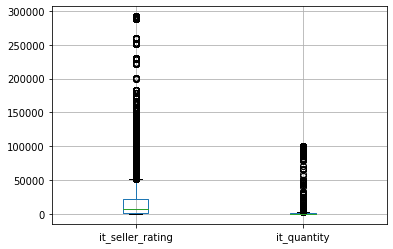

In [150]:
pd.DataFrame(num_data[['it_seller_rating', 'it_quantity']]).boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a3c910190>,
      dtype=object)

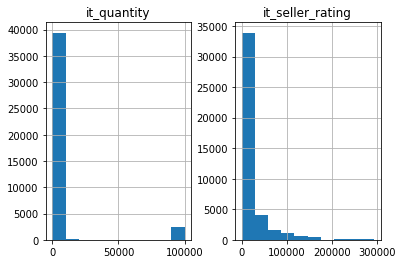

In [255]:
pd.DataFrame(num_data[['it_seller_rating', 'it_quantity']]).hist()

### Wyniki: braki w kolumnie 'it_seller_rating'
Średnia wartość RMSE wyniosła około 11367 co dla zmiennej o zakresie wartości 0-292069 oraz dużym odchyleniu standardowym jest stosunkowo dobrym wynikiem. Odchylenie standardowe RMSE wyniosło około 269.

In [139]:
case1.describe()

,seller_rating
count,10.000000
mean,11366.898164
std,268.828492
min,11018.355410
25%,11167.687359
50%,11297.175354
75%,11563.609509
max,11795.518512


Text(0, 0.5, 'wartość RMSE')

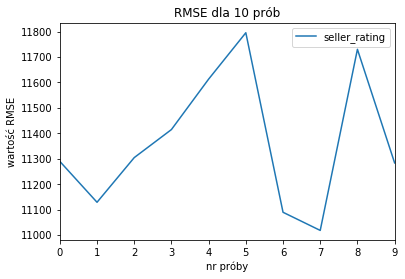

In [251]:
case1.plot(title="RMSE dla 10 prób")
plt.xlabel("nr próby")
plt.ylabel("wartość RMSE")

### Wyniki: braki w kolumnach 'it_seller_rating' oraz 'it_quantity'
Jakość imputacji dla kolumny 'it_seller_rating' nieznacznie się pogorszyła, lecz wciąż jest zadowalająca.\
Trudniejsza w ocenie jest imputacja dla kolumny 'it_quantity'. Zmienna charakteryzuje się dużym rozproszeniem wartości. RMSE imputacji w tej kolumnie wyniosło średnio około 7316. Jest to więcej niż średnia oryginalnych wartości tej kolumny. Z drugiej strony RMSE wynosi około 1/3 odchylenia standardowego tej zmiennej co wskazuje, że imputacja poradziła sobie przyzwoicie z jej rozproszeniem. 

In [141]:
case2.describe()

,seller_rating,quantity
count,10.000000,10.000000
mean,11483.067572,7316.220259
std,272.277292,183.821139
min,11114.368101,7080.131998
25%,11291.094511,7191.335564
50%,11458.954988,7257.414017
75%,11670.619455,7484.752576
max,11920.774276,7573.462096


Text(0, 0.5, 'wartość RMSE')

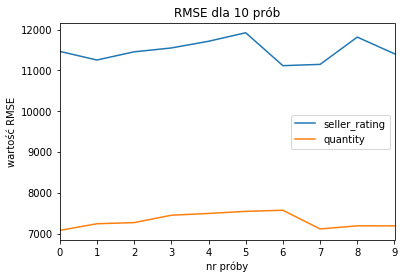

In [252]:
case2.plot(title="RMSE dla 10 prób")
plt.xlabel("nr próby")
plt.ylabel("wartość RMSE")

### Wizualizacja imputacji dla przykładowych 100 braków obserwacji 'it_seller_rating'

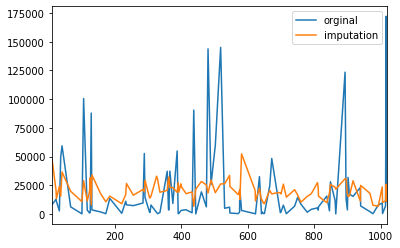

In [254]:
knn_imp = KNNImputer(n_neighbors=200)
result = pd.DataFrame(knn_imp.fit_transform(mis1))
x = np.array(num_data['it_seller_rating'])
y = np.array(result[1].astype(int))
b = pd.DataFrame({'orginal': x, 'imputation': y, 'błąd_bezwzględny': abs(x-y)})
z = b.loc[b['błąd_bezwzględny']!=0]
z.iloc[0:100, 0:2].plot()

# Podsumowanie
Metoda najbliższych sąsiadów osiągnęła dobre wyniki imputacji braków danych według miary RMSE. Warto zauważyć, że zmienne z brakami były mocno rozproszone o niesymetrycznym rozkładzie. Pomimo tego jakość imputacji była wysoka i stabilna względem losowo generowanych próbek braków.